In [1]:
# coding: utf-8
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor

import sklearn.kernel_approximation
import scipy.optimize as opt
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
class GPAL(object):
    '''Class for Gaussian Process Active Learning (Regression)
    Apply batch AL in this class
    
    Attributes
    ----------------------------
    '''

    def __init__(self, x, y, num, alpha): 
        '''
        Parameters
        --------------------------
        x
            n_samples x n_dim array
        y
            n_samples x n_labels array
        num 
            int, the number of recommendations in each iteration
        alpha 
            float or array-like
            parameter for sklearn.gaussian_process.GaussianProcessRegressor
            Value added to the diagonal of the kernel matrix during fitting
        '''
        self.x = x
        self.y = y
        self.num = num
        self.alpha = alpha

        self.mu = np.zeros_like(x)[:,0]
        self.sigma = 0.5 * np.ones_like(x)[:,0]
        self.cov = np.zeros((self.x.shape[0], self.x.shape[0]))
        
        # observed X and Y
        self.X = []
        self.Y = []
        
        # unobserved index
        self.unobserved = np.ones_like(self.x).reshape((-1,))
    
    def RandomRecommender(self):
        '''Randomly Recommend instances 
        '''
        return np.random.choice(np.arange(self.x.shape[0])[self.unobserved == 1],
                                self.num, replace = False)
    
    def MaxVarianceRecommender(self):
        '''Recommend instances to get labels based on variance
        Returns
        ----------------------------
        Sequence[int]
            Index of instances to label    
        '''
        size = num * 4
        
        # recommendations for subset size
        sorted_sigma = np.argsort(self.sigma)
        
        recommendations = []
        for i in sorted_sigma[::-1]:
            if self.unobserved[i] == 1:
                recommendations.append(i)
            if len(recommendations) == size:
                break
        #print('recommendations:', recommendations)
        
        # uncertainty scores
        uncer_score = self.sigma[sorted_sigma[::-1][:size]]
        if uncer_score.sum() != 0:
            uncer_score = uncer_score / np.linalg.norm(uncer_score)
        #print('uncer_score:', uncer_score)
        
        # construct similarity matrix
        simi_matrix = np.zeros((size, size))
        simi_score = np.zeros((size))
        
        for i in range(size):
            for j in range(size):
                simi_matrix[i,j] = self.cov[i,j]
            simi_score[i] = simi_matrix[i,:].sum()
            
        if simi_score.sum() != 0:
            simi_score = simi_score / np.linalg.norm(simi_score)
            
        #print('simi matrix shape:', simi_matrix.shape)
        #print('simi matrix:', simi_matrix)
        #print('simi score:', simi_score)
        
        
        # recommendations with total score
        recom_dict = {} # keys: recomemndation index; values: score
        beta = 0.5
        for i, rec in enumerate(recommendations):
            recom_dict[rec] = (1 - beta) * uncer_score[i] + beta * simi_score[i]
        sorted_recom_dict = sorted(recom_dict.items(), key=lambda kv: kv[1], reverse = True)
        #print(sorted_recom_dict)
        
        new_recommendations = []
        for key, value in sorted_recom_dict:
            if len(new_recommendations) < num:
                new_recommendations.append(key)
        #print('new recommendations:', new_recommendations)
        
        return new_recommendations

    def predictor(self):
        '''Predict both the mean value and variance of instances
        '''
        gp = GaussianProcessRegressor(alpha = self.alpha)
        gp.fit(self.X, self.Y)
        self.mu, self.sigma = gp.predict(self.x, return_std=True)
        self.mu, self.cov = gp.predict(self.x, return_cov=True)
        #print(self.cov)
    
    def labeller(self, recommendations):
        '''Label the recommended instances
        
        Parameters
        -----------------------------------
        recommendations
            list of recommendations index
            
        Returns
        -----------------------------------
        Sequence[int], Sequence[float]
            indexs and values(labels) of observed isntances
        '''
        for r in recommendations: 
            self.X.append(self.x[r])
            self.Y.append(self.y[r])
            self.unobserved[r] = 0 

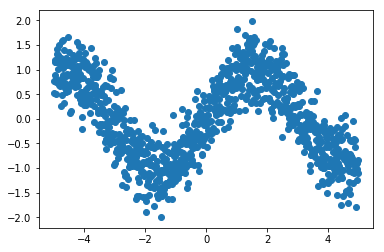

In [3]:
# Let get some data       
x = np.arange(-5, 5, 0.01).reshape((-1,1))
y = np.sin(x) + 2 * np.random.normal(0,0.2,x.shape)
plt.scatter(x, y)

0 [999, 328, 341, 340, 339]
1 [687, 677, 678, 688, 686]
2 [9, 10, 8, 11, 7]
3 [509, 151, 169, 152, 168]
4 [865, 846, 864, 847, 863]
5 [430, 426, 429, 584, 427]
6 [82, 250, 72, 242, 249]
7 [770, 771, 769, 772, 768]
8 [941, 940, 942, 939, 943]
9 [606, 607, 605, 608, 604]
10 [998, 997, 514, 513, 515]
11 [58, 59, 57, 60, 56]
12 [286, 287, 285, 288, 284]
13 [209, 210, 208, 211, 207]
14 [0, 120, 121, 119, 122]
15 [377, 378, 376, 379, 375]
16 [996, 995, 465, 466, 464]
17 [548, 549, 547, 550, 546]
18 [814, 815, 813, 816, 812]
19 [896, 897, 895, 898, 894]


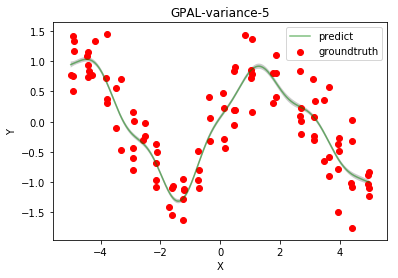

In [4]:
alpha = 0.01 
num = 5
iteration = 20
GPAgent = GPAL(x,y,num,alpha)
variance5_loss = []
for i in range(iteration):
    recommendations = GPAgent.MaxVarianceRecommender() 
    print(i,recommendations)
    GPAgent.labeller(recommendations)
    GPAgent.predictor()
    variance5_loss.append(mean_squared_error(y[:,0], GPAgent.mu[:,0]))

plt.plot(GPAgent.x, GPAgent.mu, alpha=0.5, color='g', label = 'predict')
plt.fill_between(GPAgent.x[:,0], GPAgent.mu[:,0] + GPAgent.sigma,
                GPAgent.mu[:,0] - GPAgent.sigma, facecolor='k', alpha=0.2)
plt.scatter(GPAgent.X, GPAgent.Y, c='r', marker='o', alpha=1.0, label = 'groundtruth')
plt.legend()

plt.xlabel('X')
plt.ylabel('Y')
plt.title('GPAL-variance-5')
plt.show()

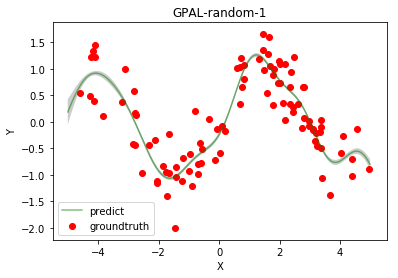

In [5]:
alpha = 0.01 
num = 1
iteration = 100
GPAgent = GPAL(x,y,num,alpha)
random_loss = []
for i in range(iteration):
    recommendations = GPAgent.RandomRecommender() 
    GPAgent.labeller(recommendations)
    GPAgent.predictor()
    random_loss.append(mean_squared_error(y[:,0], GPAgent.mu[:,0]))

plt.plot(GPAgent.x, GPAgent.mu, alpha=0.5, color='g', label = 'predict')
plt.fill_between(GPAgent.x[:,0], GPAgent.mu[:,0] + GPAgent.sigma,
                GPAgent.mu[:,0] - GPAgent.sigma, facecolor='k', alpha=0.2)
plt.scatter(GPAgent.X, GPAgent.Y, c='r', marker='o', alpha=1.0, label = 'groundtruth')
plt.legend()

plt.xlabel('X')
plt.ylabel('Y')
plt.title('GPAL-random-1')
plt.show()

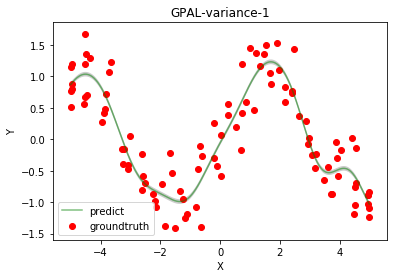

In [6]:
alpha = 0.01 
num = 1
iteration = 100
GPAgent = GPAL(x,y,num,alpha)
variance1_loss = []
for i in range(iteration):
    recommendations = GPAgent.MaxVarianceRecommender() 
    #print(recommendations)
    GPAgent.labeller(recommendations)
    GPAgent.predictor()
    variance1_loss.append(mean_squared_error(y[:,0], GPAgent.mu[:,0]))

plt.plot(GPAgent.x, GPAgent.mu, alpha=0.5, color='g', label = 'predict')
plt.fill_between(GPAgent.x[:,0], GPAgent.mu[:,0] + GPAgent.sigma,
                GPAgent.mu[:,0] - GPAgent.sigma, facecolor='k', alpha=0.2)
plt.scatter(GPAgent.X, GPAgent.Y, c='r', marker='o', alpha=1.0, label = 'groundtruth')
plt.legend()

plt.xlabel('X')
plt.ylabel('Y')
plt.title('GPAL-variance-1')
plt.show()

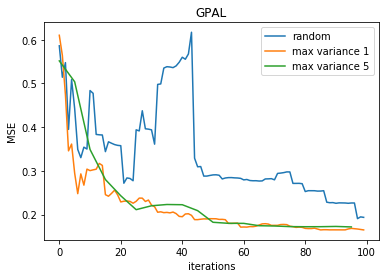

In [8]:
# plot cumulative regret
iteration = 100
plt.plot(range(iteration), random_loss, label = 'random')
plt.plot(range(iteration), variance1_loss, label = 'max variance 1')
plt.plot(range(iteration)[::5], variance5_loss[:20], label = 'max variance 5')
plt.xlabel('iterations')
plt.ylabel('MSE')
plt.title('GPAL')
plt.legend()